## ARIMA Modelling

ARIMA is a time series forecasting model that incorporates autocorrelation measures to model temporal structures within the time series data to predict future values. It stands for autoregression (AR), differencing (I), and moving average (MA). Each of these components corresponds to a parameter in the ARIMA model, typically denoted as (p,d,q).

p: Number of lag observations (AR).
d: Number of differencing steps to make the series stationary.
q: Number of lagged forecast errors (MA).

### Import Relevant Libraries and Data

In [41]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller

In [50]:
df = pd.read_csv("../data/preprocessed_stock_data.csv")
df.Date = pd.to_datetime(df.Date).dt.date

In [51]:
df.head()

,Date,StockValue
0,2015-01-02,27.05
1,2015-01-09,26.36
2,2015-01-16,24.96
3,2015-01-23,25.64
4,2015-01-30,27.06


### Split data into train and test data

In [53]:
df.set_index('Date', inplace=True)

In [54]:
df.head()

,StockValue
Date,
2015-01-02,27.05
2015-01-09,26.36
2015-01-16,24.96
2015-01-23,25.64
2015-01-30,27.06


In [57]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### Check for stationarity

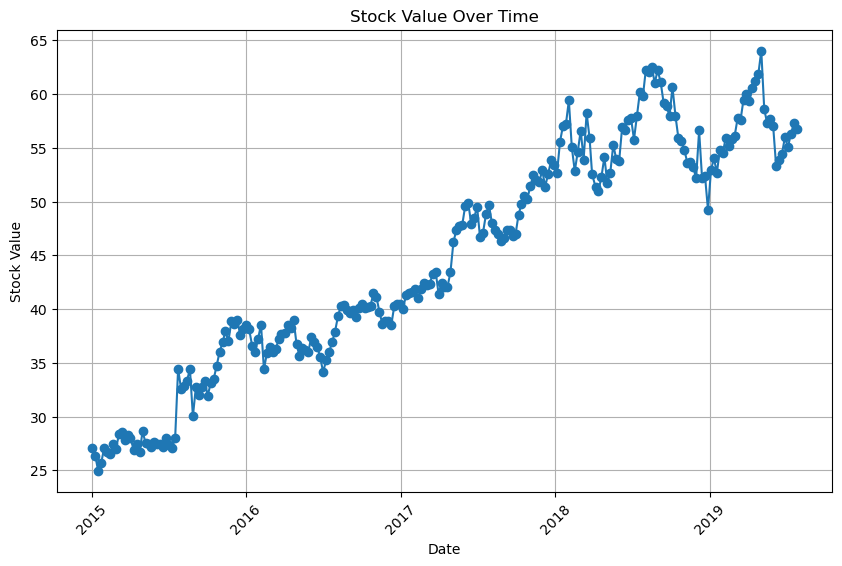

In [59]:
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(train.index, train['StockValue'], marker='o')

# Adding titles and labels
plt.title('Stock Value Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Value')

# Optional: Rotate x-axis labels if dates overlap
plt.xticks(rotation=45)

# Show grid for better readability
plt.grid(True)

We have an increasing stock value over time with an increasing amplitude. So we are in the case of a multiplicative model where the time series is a product of trend, seasonality and residues (contrary to the additive model where it is the sum)

Now we want to check stationarity of the data because the ARMA can only model stationary processes. Stationarity means that the series has no correlation and collinearity with the past data. 

From the graph above we can already guess that there is a correlation with past data but to be sure we can use  an Augmented Dickey-Fuller (ADF) test where the null hypothesis states the null hypothesis that the series is non-stationary.

In [60]:
# Perform ADF test
adf_result = adfuller(train.StockValue)

# Output the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.4548886355308324
p-value: 0.5556976898709065
Critical Values:
	1%: -3.4583663275730476
	5%: -2.8738660999177132
	10%: -2.5733390785693766


The p-value is greater than 0.05, so we cannot reject the null hypothesis which indicates the series is likely not stationary. So we have to make the time series stationary. 

### Figuring out parameter d: Number of differentiating steps to make time series stationary

The most common method to make a time series stationary is differencing. To determine how many times we need to differentiate, i.e. the parameter d, we can use the Autocorrelation function (ACF). 

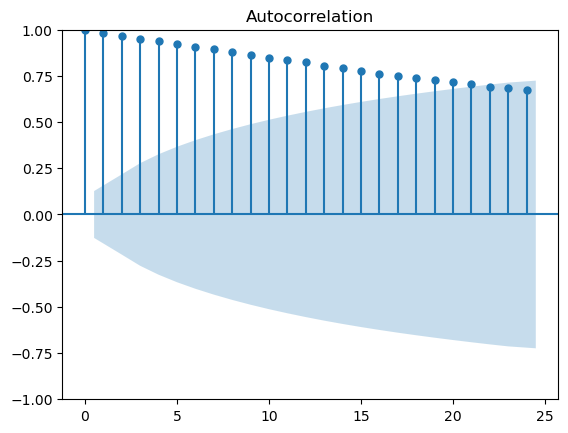

In [62]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train)

plt.show()

From the graph we can see, that is not ideal for ARIMA, let's differentiate the data and see how the autocorrelaton changes

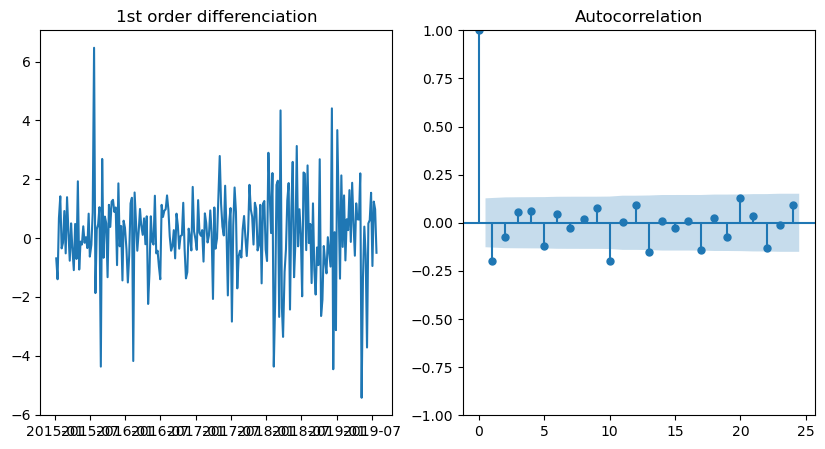

In [67]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().dropna(), ax=ax2)
plt.show()

The differentiate data looks a lot more stationary. Although we still have some autocorrelated data. Let's do a second differentiating to check if it further improves the stationarity.

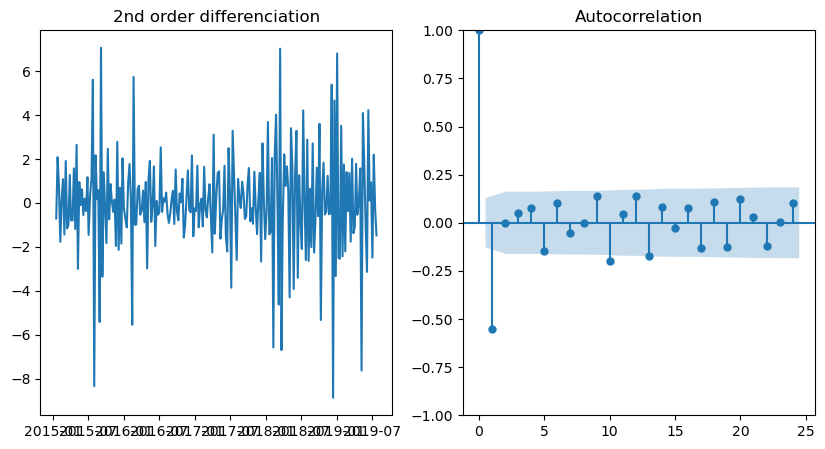

In [68]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differenciation')
ax1.plot(train.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(train.diff().diff().dropna(), ax=ax2)
plt.show()

Let's cross-check with a Augmented Dicky Fuller Test what the best oder for differentiating is

In [74]:
# Perform ADF test
#No differentiating
result1 = adfuller(train)
print('Original p-value:', result1[1])

#First order differentiating 
result2 = adfuller(train.diff().dropna())
print('1st order p-value:', result2[1])

#Second order differentiating
result3 = adfuller(train.diff().diff().dropna())
print('2nd order p-value:', result3[1])


Original p-value: 0.5556976898709065
1st order p-value: 5.5612589691963485e-25
2nd order p-value: 1.4957790735280433e-11


1st order differentiating seems to be enough to make data stationary (p-value < 0.05), thus d = 2.

### Figuring out parameter p: Number of lag observations (AR)

To figure out p we can we can inspect the partial autocorrelation plot, which measures the correlation between the time-series data and a certain lag. 

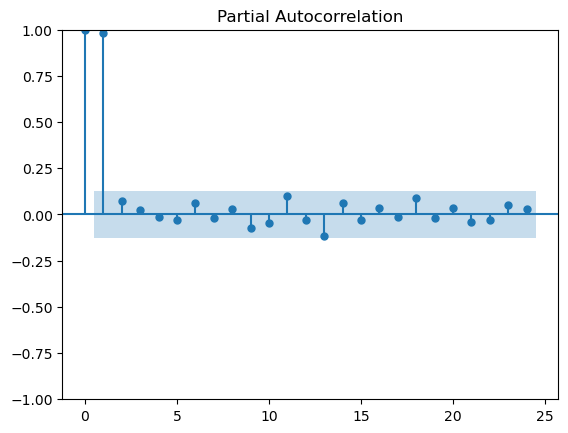

In [75]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train)

plt.show()

The first two lags seems to be the most significant lags, let's differntiate the data and check again.

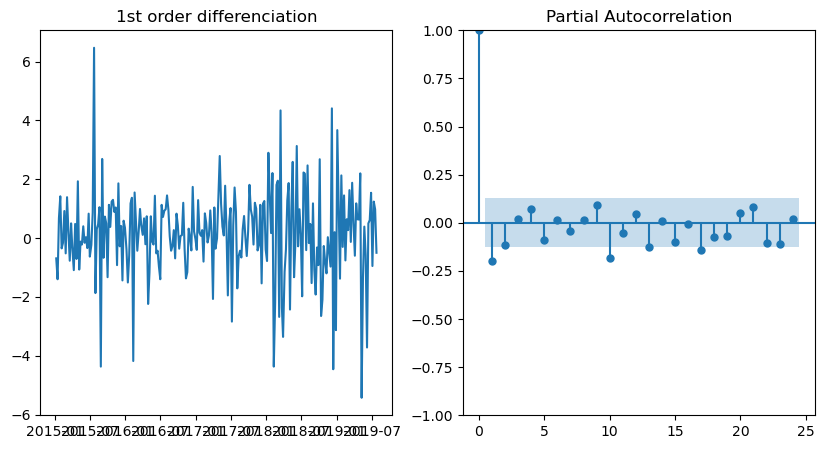

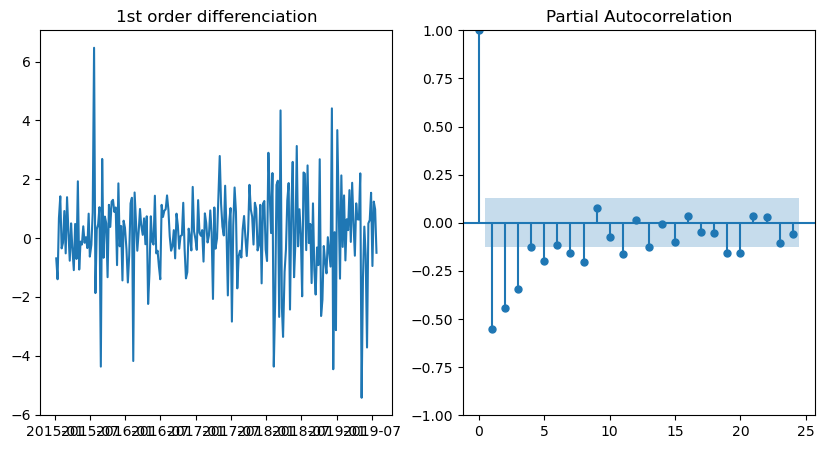

In [87]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_pacf(train.diff().dropna(), ax=ax2)
plt.show()

f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differenciation')
ax1.plot(train.diff())

ax2 = f.add_subplot(122)
plot_pacf(train.diff().diff().dropna(), ax=ax2)
plt.show()

In both the plots, we see the 1st lag is the most significant. Thus, we consider “p” to be 1. In the second order differentiating PACF graph are too many negative values which might indicate over-differntiation.

### Figuring out parameter q : Number of lagged forecast errors (MA).

We can look at the ACF graph again. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. Here q = 3. 

### Fit the ARIMA model

In [82]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.StockValue, order=(1, 1, 3)) #ARIMA(p=1, d=1, q=3)

results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             StockValue   No. Observations:                  239
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -429.489
Date:                Tue, 03 Sep 2024   AIC                            868.978
Time:                        17:59:44   BIC                            886.339
Sample:                             0   HQIC                           875.975
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1369      0.753      0.182      0.856      -1.338       1.612
ma.L1         -0.3445      0.747     -0.461      0.645      -1.809       1.120
ma.L2         -0.0105      0.167     -0.063      0.9

/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The AR(1) term and MA terms (L1, L2, L3) all have high p-values, suggesting that these coefficients may not be statistically significant. This could imply that the model might not be capturing the underlying process effectively or that the chosen orders for AR and MA terms might not be optimal.

Let's try with second order differentiating. And if it doesn't give better results, we can try SARIMA model where seasonality is also captureD. 

In [86]:
model = ARIMA(train.StockValue, order=(1, 2, 3)) #ARIMA(p=1, d=2, q=3)

results = model.fit()

print(results.summary())

/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/claudia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             StockValue   No. Observations:                  239
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -430.455
Date:                Tue, 03 Sep 2024   AIC                            870.910
Time:                        18:04:56   BIC                            888.251
Sample:                             0   HQIC                           877.900
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9617      0.181     -5.303      0.000      -1.317      -0.606
ma.L1         -0.2640      2.920     -0.090      0.928      -5.987       5.459
ma.L2         -0.9421      2.098     -0.449      0.6